# Volumetric VAE with the class weight

In [1]:
from utils import *

import os
import datetime

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.path.append("/home/dongwonshin/Desktop/Open3D/build/lib")
from py3d import *

from VolumetricVAE import *

# Volumetric VAE Model training

In [4]:
vol_vae = VolumetricVAE(_kernel_size=3, _stride=1)
vol_vae = torch.nn.DataParallel(vol_vae, device_ids = range(torch.cuda.device_count()))
vol_vae.cuda()

optimizer = optim.Adam(vol_vae.parameters(), lr=0.0001)

class_weight = torch.Tensor(np.array(
    [0.025192871093750013,
     0.99568359375,
     0.9951199340820313,
     0.9965753173828125,
     0.998511962890625,
     0.9998382568359375,
     0.9990286254882812,
     0.9993521118164063,
     0.9994937133789062,
     0.9998776245117188,
     0.9997113037109375,
     1.0,
     0.9998117065429688,
     0.9989590454101562,
     0.9985369873046875,
     0.9993685913085938,
     1.0,
     1.0,
     0.9990896606445312,
     0.999835205078125,
     0.9960134887695312]
)).cuda()

recon_loss_func = torch.nn.CrossEntropyLoss(weight=class_weight)

In [5]:
epoches = 300
data_range = 100

for epoch in range(epoches):
    for idx in range(data_range):
        comp_pcd = read_point_cloud("/home/dongwonshin/Desktop/subvolume_dataset_making/mesh_results2/%06d_complete.ply" % idx)
        voxel_volume, color_volume = pcd2voxel(comp_pcd)
        
        input_volume = colorvol2classidvol(color_volume)
        input_volume = np.expand_dims(input_volume, axis=0) # fake batch axis
        input_volume = torch.from_numpy(input_volume).float() 
        input_volume = Variable(input_volume).cuda()

        optimizer.zero_grad()
        
        output_volume, z_mean, z_sigma = vol_vae.forward(input_volume)
        
        target_volume = colorvol2classidvol(color_volume, False)
        target_volume = np.expand_dims(target_volume, axis=0) # fake batch axis
        target_volume = torch.from_numpy(target_volume).long() 
        target_volume = Variable(target_volume).cuda()
        
        mean_sq = z_mean * z_mean
        stddev_sq = z_sigma * z_sigma
        kl_loss = 0.5 * torch.sum(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)
        recon_loss = recon_loss_func(output_volume, target_volume)
        
        loss = recon_loss + kl_loss
        
        loss.backward()
        optimizer.step()

        l = loss.data[0]
    
    print(l)

    # save the intermediate result
    argmaxed = torch.argmax(output_volume,1)
    output_color_volume = classidvol2colorvol(argmaxed.cpu().numpy())
    viz_vvae_output(output_color_volume,'./result_vvae_with_classweight',show=False,save=True)
    

/home/dongwonshin/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/dongwonshin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(2.4152, device='cuda:0')
tensor(2.3829, device='cuda:0')
tensor(2.3506, device='cuda:0')
tensor(2.3032, device='cuda:0')
tensor(2.2259, device='cuda:0')
tensor(2.1261, device='cuda:0')
tensor(1.9607, device='cuda:0')
tensor(1.9238, device='cuda:0')
tensor(1.8548, device='cuda:0')
tensor(1.8638, device='cuda:0')
tensor(1.7605, device='cuda:0')
tensor(1.7324, device='cuda:0')
tensor(1.7639, device='cuda:0')
tensor(1.7222, device='cuda:0')
tensor(1.7059, device='cuda:0')
tensor(1.6607, device='cuda:0')
tensor(1.7274, device='cuda:0')
tensor(1.6378, device='cuda:0')
tensor(1.6607, device='cuda:0')
tensor(1.6313, device='cuda:0')
tensor(1.5891, device='cuda:0')
tensor(1.6082, device='cuda:0')
tensor(1.6551, device='cuda:0')
tensor(1.6891, device='cuda:0')
tensor(1.5942, device='cuda:0')
tensor(1.6788, device='cuda:0')
tensor(1.6582, device='cuda:0')
tensor(1.6571, device='cuda:0')
tensor(1.6422, device='cuda:0')
tensor(1.5868, device='cuda:0')
tensor(1.6086, device='cuda:0')
tensor(1

In [32]:
torch.save(vol_vae, 'vol_vae_small_dataset.pt')

In [33]:
model = torch.load('vol_vae_small_dataset.pt')

In [34]:
model

DataParallel(
  (module): VolumetricVAE(
    (encoder): Encoder(
      (conv3d_1): Conv3d(21, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool3d_1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3d_2): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool3d_2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3d_3): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (pool3d_3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (decoder): Decoder(
      (conv3d_1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (upsample_1): Upsample(scale_factor=2, mode=trilinear)
      (conv3d_2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (upsample_2): Upsample(scale_factor=2, mode=trilinear)
      (conv3d_3): Conv3d(128, 21, ke

/home/dongwonshin/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


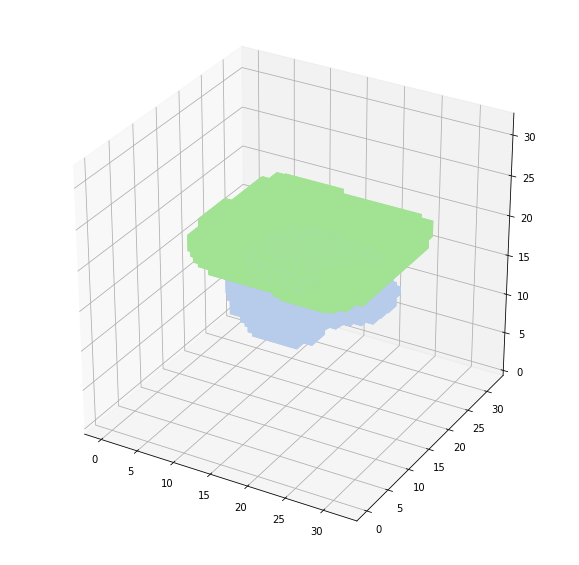

In [44]:
idx = 20
comp_pcd = read_point_cloud("/home/dongwonshin/Desktop/subvolume_dataset_making/mesh_results2/%06d_complete.ply" % idx)
voxel_volume, color_volume = pcd2voxel(comp_pcd)

input_volume = colorvol2classidvol(color_volume)
input_volume = np.expand_dims(input_volume, axis=0) # fake batch axis
input_volume = torch.from_numpy(input_volume).float() 
input_volume = Variable(input_volume).cuda()

output_volume = model.forward(input_volume)

argmaxed = torch.argmax(output_volume[0],1)
output_color_volume = classidvol2colorvol(argmaxed.cpu().numpy())
viz_vvae_output(output_color_volume,'./result_vvae_with_classweight',show=True,save=False)

# class weight calculation

In [9]:
class_count_array = []

In [10]:
class_count_array.append([641010537,   3127005,   3557042,    501871,    244061,   1111810,    632902,
    662104,    577106,    306848,    414835,     98997,    112252,    278896,
    161712,     83703,     72063,     57584,    481734,    205316,   1661622])

In [12]:
class_count_array.append([641015042,   3231357,   3712139,    638414,    329425,   1156217,    342847,
    660821,    476805,    331603,    239301,    148460,    147563,    287478,
    123720,     68871,    112249,    108068,    537011,    265446,   1427163])

In [13]:
class_count_array.append([640843927,   3020689,   3560221,    531094,   578115,   1161070,    504929,
    589628,    489529,    338042,    484875,    176051,    165879,    346662,
    246601,     71095,     84052,     36200,    400185,    162121,   1569035])

In [14]:
class_count_array.append([641384122,   3247276,   3152032,    655478,    289110,   1084961,    488832,
    640733,    439471,    386958,    285192,    163884,    161130,    315588,
    170840,     72971,     37978,     23574,    510443,    236091,   1613336])

In [15]:
class_count_array.append([641212090,   3108148,   3277431,    629036,    266530,   1334283,    346489,
    547983,    499836,    333100,    419179,    131834,    147040,    256511,
    109769,     91724,    140593,    125575,    368896,    257674,   1756279])

In [16]:
class_count_array.append([641213615,   3069689,   3455505,    515571,    341245,    944151,    419633,
    510941,    576788,    353185,    326778,    114072,    166146,    193401,
    196574,     78953,    142709,    139578,    483737,    321585,   1796144])

In [17]:
class_count_array.append([641096657,   3121933,   3100722,    623113,    353947,   1084730,    453549,
    594554,    373350,    327625,    369656,    125180,    163492,    293457,
    243647,     83864,    133220,    108207,    645905,    293724,   1769468])

In [18]:
class_count_array.append([653835248,    295751,   396826,     50110,     87646,     74088,     81337,
     52219,     48673,     26546,     57005,     24073,      8752,     16762,
     54143,       478,     19590,      6557,     34643,     11765,    177788])

In [19]:
class_count_array.append([67615728,   295751,   396826,    50110,    87646,    74088,    81337,    52219,
    48673,    26546,    57005,    24073,     8752,    16762,    54143,      478,
    19590,     6557,    34643,    11765,   177788])

In [22]:
class_count_array = np.array((class_count_array))

In [26]:
class_count_array = np.sum(class_count_array,0)

In [28]:
total_count = np.sum(class_count_array)

In [31]:
1-class_count_array/total_count

array([0.01935111, 0.99576101, 0.99536735, 0.99921032, 0.99951474,
       0.9984892 , 0.99936901, 0.99918841, 0.99933543, 0.99954246,
       0.99950041, 0.9998105 , 0.9997965 , 0.99962246, 0.99974376,
       0.99989606, 0.99985654, 0.99988481, 0.99934164, 0.99966764,
       0.99775064])